**-Bộ dữ liệu Housing Prices Dataset do M Yasser H chia sẻ trên Kaggle là một tập dữ liệu nhỏ gọn, lý tưởng cho việc học và thực hành các kỹ thuật phân tích dữ liệu, đặc biệt là dự đoán giá nhà thông qua các mô hình hồi quy.**

-Tổng quan về dữ liệu
Tên: Housing Prices Dataset

Nguồn: Kaggle - Housing Prices Dataset
Loại bài toán: Hồi quy (Regression)
Định dạng: CSV

=> Mục tiêu: Dự đoán giá nhà dựa trên các đặc trưng như diện tích, số phòng ngủ, tình trạng nội thất, vị trí gần đường chính, v.v..

-Mô tả các đặc trưng chính
Dữ liệu bao gồm các cột sau:

* price: Giá nhà (biến mục tiêu)
* area: Diện tích nhà
* bedrooms: Số phòng ngủ
* bathrooms: Số phòng tắm
* stories: Số tầng
* mainroad: Nhà có nằm gần đường chính không (yes/no)
* guestroom: Có phòng khách không (yes/no)
* basement: Có tầng hầm không (yes/no)
* hotwaterheating: Có hệ thống nước nóng không (yes/no)
* airconditioning: Có điều hòa không khí không (yes/no)
* parking: Số chỗ đậu xe
* prefarea: Nhà có nằm trong khu vực ưu tiên không (yes/no)

In [1]:
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
from tabulate import tabulate
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
housing = pd.read_csv("/kaggle/input/housng-dataset/Housing.csv")
df=housing

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,1.0,3.0


In [5]:
summary = {
    "Thông tin": [
        "Số lượng bản ghi (dòng)",
        "Số lượng biến (cột)",
        "Số dòng bị trùng lặp hoàn toàn",
        "Tổng số giá trị bị thiếu (missing values)"
    ],
    "Giá trị": [
        len(df),
        df.shape[1],
        df.duplicated().sum(),
        df.isnull().sum().sum()  # Tổng số ô bị missing
    ]
}

summary_df = pd.DataFrame(summary)

print("\nBẢNG TÓM TẮT THÔNG TIN DỮ LIỆU")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))


BẢNG TÓM TẮT THÔNG TIN DỮ LIỆU
╒═══════════════════════════════════════════╤═══════════╕
│ Thông tin                                 │   Giá trị │
╞═══════════════════════════════════════════╪═══════════╡
│ Số lượng bản ghi (dòng)                   │       545 │
├───────────────────────────────────────────┼───────────┤
│ Số lượng biến (cột)                       │        13 │
├───────────────────────────────────────────┼───────────┤
│ Số dòng bị trùng lặp hoàn toàn            │         0 │
├───────────────────────────────────────────┼───────────┤
│ Tổng số giá trị bị thiếu (missing values) │         0 │
╘═══════════════════════════════════════════╧═══════════╛


In [6]:
column_info = pd.DataFrame({
    "Tên cột": df.columns,
    "Kiểu dữ liệu": df.dtypes.values,
    "Số giá trị không null": df.notnull().sum().values,
    "Số giá trị null": df.isnull().sum().values,
    "Tỷ lệ thiếu (%)": (df.isnull().sum().values / len(df) * 100).round(2)
})

print("\nBẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU")
print(tabulate(column_info, headers='keys', tablefmt='fancy_grid', showindex=False))


BẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU
╒══════════════════╤════════════════╤═════════════════════════╤═══════════════════╤═══════════════════╕
│ Tên cột          │ Kiểu dữ liệu   │   Số giá trị không null │   Số giá trị null │   Tỷ lệ thiếu (%) │
╞══════════════════╪════════════════╪═════════════════════════╪═══════════════════╪═══════════════════╡
│ price            │ int64          │                     545 │                 0 │                 0 │
├──────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ area             │ int64          │                     545 │                 0 │                 0 │
├──────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ bedrooms         │ int64          │                     545 │                 0 │                 0 │
├──────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ bathrooms        │ i

**Nhận xét:** Từ thu thông tin từ bảng trên ta thấy dữ liệu đã được xử lý tốt từ giai đoạn thu thập, khi không tồn tại các giá trị bị thiếu hay các dòng bị trùng lặp. Nhờ đó, các phân tích thống kê sau này có thể được tiến hành một cách hiệu quả và đáng tin cậy. Điều này giúp đảm bảo rằng mọi kết quả thu được đều phản ánh chính xác mối liên hệ giữa các biến. 

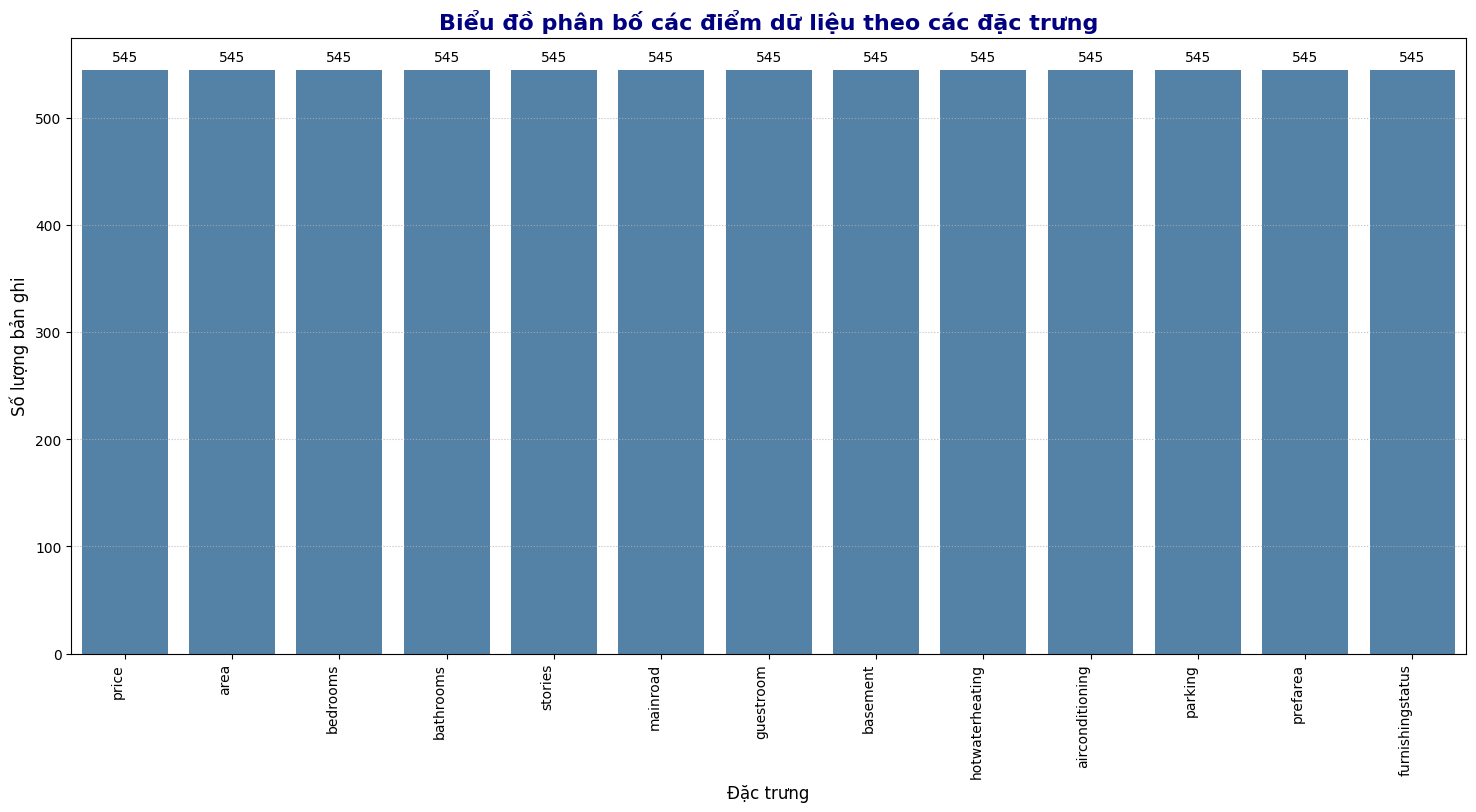

In [7]:
num_of_record = df.shape[0]
non_missing_counts = df.notna().sum()

plt.figure(figsize=(18, 8))
colors = ['steelblue' if value == num_of_record else 'lightskyblue' for value in non_missing_counts.values]

sns.barplot(x=non_missing_counts.index, y=non_missing_counts.values, palette=colors)

for index, value in enumerate(non_missing_counts.values):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=10)

plt.title("Biểu đồ phân bố các điểm dữ liệu theo các đặc trưng", fontsize=16, weight='bold', color="navy")
plt.xlabel("Đặc trưng", fontsize=12)
plt.ylabel("Số lượng bản ghi", fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.ylim(0, df.shape[0] + 30)

plt.grid(axis='y', linestyle=':', alpha=0.8)
plt.show()

- Qua quan sát biểu đồ, nhận thấy tập dữ liệu không xuất hiện giá trị bị thiếu. Tuy nhiên, trong thực tế, việc xuất hiện dữ liệu thiếu là tình huống khá phổ biến và cần được xử lý phù hợp để đảm bảo tính toàn vẹn và độ tin cậy của phân tích.

- Trong trường hợp xuất hiện giá trị thiếu, có thể áp dụng một số phương pháp xử lý phổ biến như sau:

    - **Loại bỏ:** Áp dụng khi tỷ lệ giá trị thiếu nhỏ (thông thường là dưới **5%**) và không ảnh hưởng đáng kể đến kết quả phân tích. 

    - **Thay thế bằng giá trị đặc trưng:** Đối với dữ liệu định lượng, có thể thay thế bằng giá trị mean, median hoặc mode. Đối với dữ liệu định tính, nên thay thế bằng giá trị xuất hiện với tần suất cao nhất.

    - **Nội suy**: Phù hợp với chuỗi thời gian, sử dụng xu hướng dữ liệu để dự đoán giá trị bị thiếu.

    - **Mô hình hóa hoặc học máy:** Sử dụng các mô hình như hồi quy tuyến tính, k-NN hoặc các thuật toán học máy khác để dự đoán và điền giá trị thiếu dựa trên các biến liên quan.

Việc lựa chọn phương pháp xử lý phụ thuộc vào đặc điểm của dữ liệu và mục tiêu phân tích, nhằm đảm bảo tính chính xác và khách quan trong kết quả cuối cùng.

In [8]:
duplicates = df[df.duplicated()]
print("Số dòng bị trùng lặp hoàn toàn:", duplicates.shape[0])

Số dòng bị trùng lặp hoàn toàn: 0


- Quan sát cho thấy tập dữ liệu hiện tại không có các điểm dữ liệu bị trùng lặp hoàn toàn. Tuy nhiên, trong thực tế, việc xuất hiện các dòng dữ liệu trùng lặp là tình huống phổ biến, đặc biệt khi dữ liệu được tổng hợp từ nhiều nguồn hoặc trong quá trình nhập liệu thủ công. Dữ liệu trùng lặp nếu không được xử lý có thể làm sai lệch kết quả phân tích, gây ra dư thừa hoặc thiên lệch trong thống kê.

- Để xử lý, có thể áp dụng một số phương pháp như sau:

    - **Loại bỏ hoàn toàn các dòng bị trùng lặp:** Đây là cách đơn giản nhất khi dữ liệu trùng là dư thừa và không cần giữ lại.

    - **Giữ lại một bản duy nhất:** Áp dụng khi thông tin các dòng giống nhau hoàn toàn, chỉ cần giữ bản đầu tiên hoặc cuối cùng.

    - **Kiểm tra trùng lặp theo từng cột hoặc nhóm cột:** Trong trường hợp các dòng không giống hoàn toàn nhưng có một số trường bị trùng, cần xác định rõ tiêu chí để làm sạch phù hợp.

Việc phát hiện và xử lý dữ liệu trùng lặp là bước quan trọng trong quá trình tiền xử lý dữ liệu, nhằm đảm bảo độ chính xác và độ tin cậy cho các phân tích sau này

## Dữ liệu định lượng

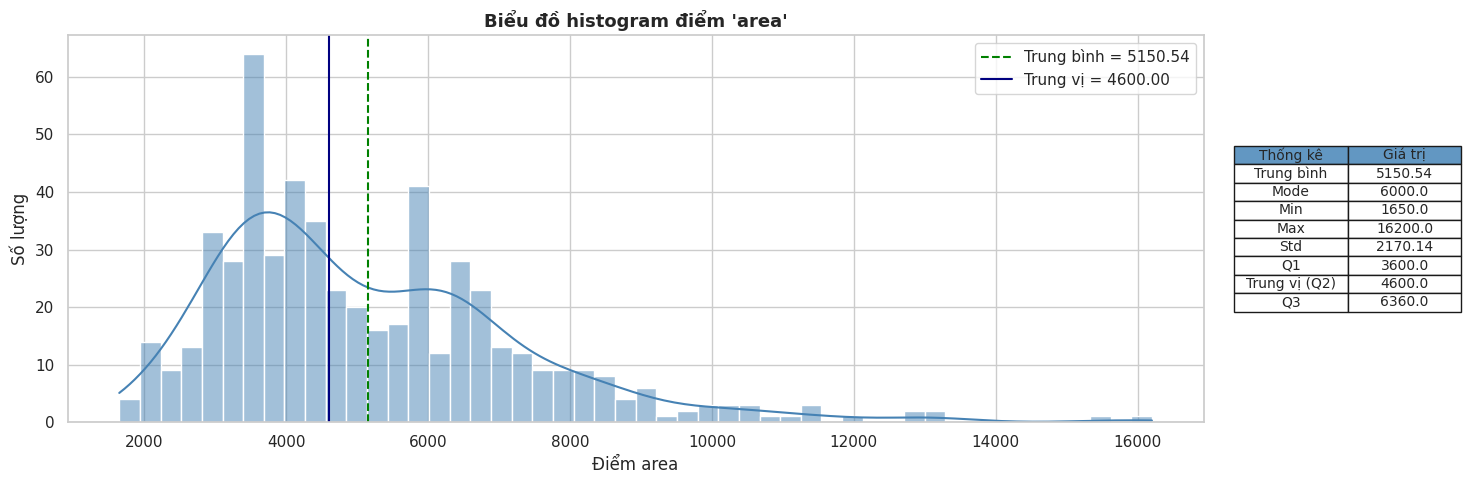

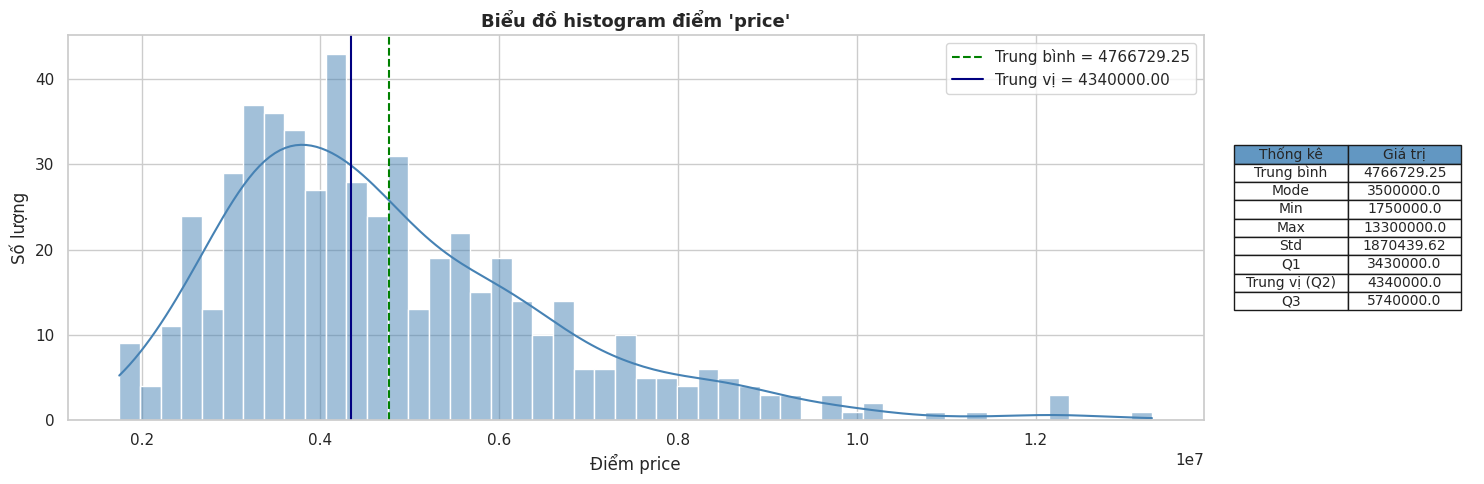

In [9]:
sns.set(style="whitegrid")
scores  = ['area', 'price']

for score in scores :
    data = df[score].dropna()
    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode().values[0] if not data.mode().empty else None
    min_val = data.min()
    max_val = data.max()
    std_val = data.std()
    q1 = data.quantile(0.25)
    q2 = data.quantile(0.50)
    q3 = data.quantile(0.75)
    
    stat_table = pd.DataFrame({
        'Thống kê': ['Trung bình','Mode', 'Min', 'Max', 'Std', 'Q1', 'Trung vị (Q2)',  'Q3'],
        'Giá trị': [round(mean_val,2), mode_val, min_val, max_val, round(std_val,2), round(q1,2),round(q2,2), round(q3,2)]
    })

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[9, 2])

    # Histogram
    ax0 = plt.subplot(gs[0])
    sns.histplot(data=df, x=score, bins=50, stat='count', kde=True, color='steelblue', ax=ax0)
    ax0.axvline(mean_val, color='green', linestyle='--', label=f'Trung bình = {mean_val:.2f}')
    ax0.axvline(median_val, color='navy', linestyle='-', label=f'Trung vị = {median_val:.2f}')
    ax0.set_title(f"Biểu đồ histogram điểm '{score}'", fontsize=13, weight='bold')
    ax0.set_xlabel(f"Điểm {score}")
    ax0.set_ylabel("Số lượng")
    ax0.legend()

    # Bảng thống kê
    ax1 = plt.subplot(gs[1])
    ax1.axis('off')
    table_plot = ax1.table(cellText=stat_table.values,
                           colLabels=stat_table.columns,
                           cellLoc='center',
                           loc='center',
                           colColours=["#6297C2", "#6297C2"])
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(10)
    table_plot.scale(0.9, 1.1)

    plt.tight_layout()
    plt.show()


Ta thấy dữ liệu area và price đều lệch phải, tức là phần lớn giá trị tập trung ở mức thấp, và có một số giá trị rất cao kéo đuôi biểu đồ dài ra.
Việc trực quan hóa bằng histogram cho phép xác định rằng dữ liệu chưa phân phối chuẩn

**Lý do sử dụng Histogram:**
Histogram không chỉ là biểu đồ hiển thị "tần suất", mà còn là công cụ then chốt giúp đưa ra quyết định trong các bước xử lý dữ liệu tiếp theo.
Trong dự án như phân tích giá nhà, biểu đồ này giúp hiểu được mức phổ biến của diện tích và giá, từ đó phân nhóm khách hàng, phát hiện bất thường hoặc xác định nhu cầu thị trường.

## Dữ liệu định tính

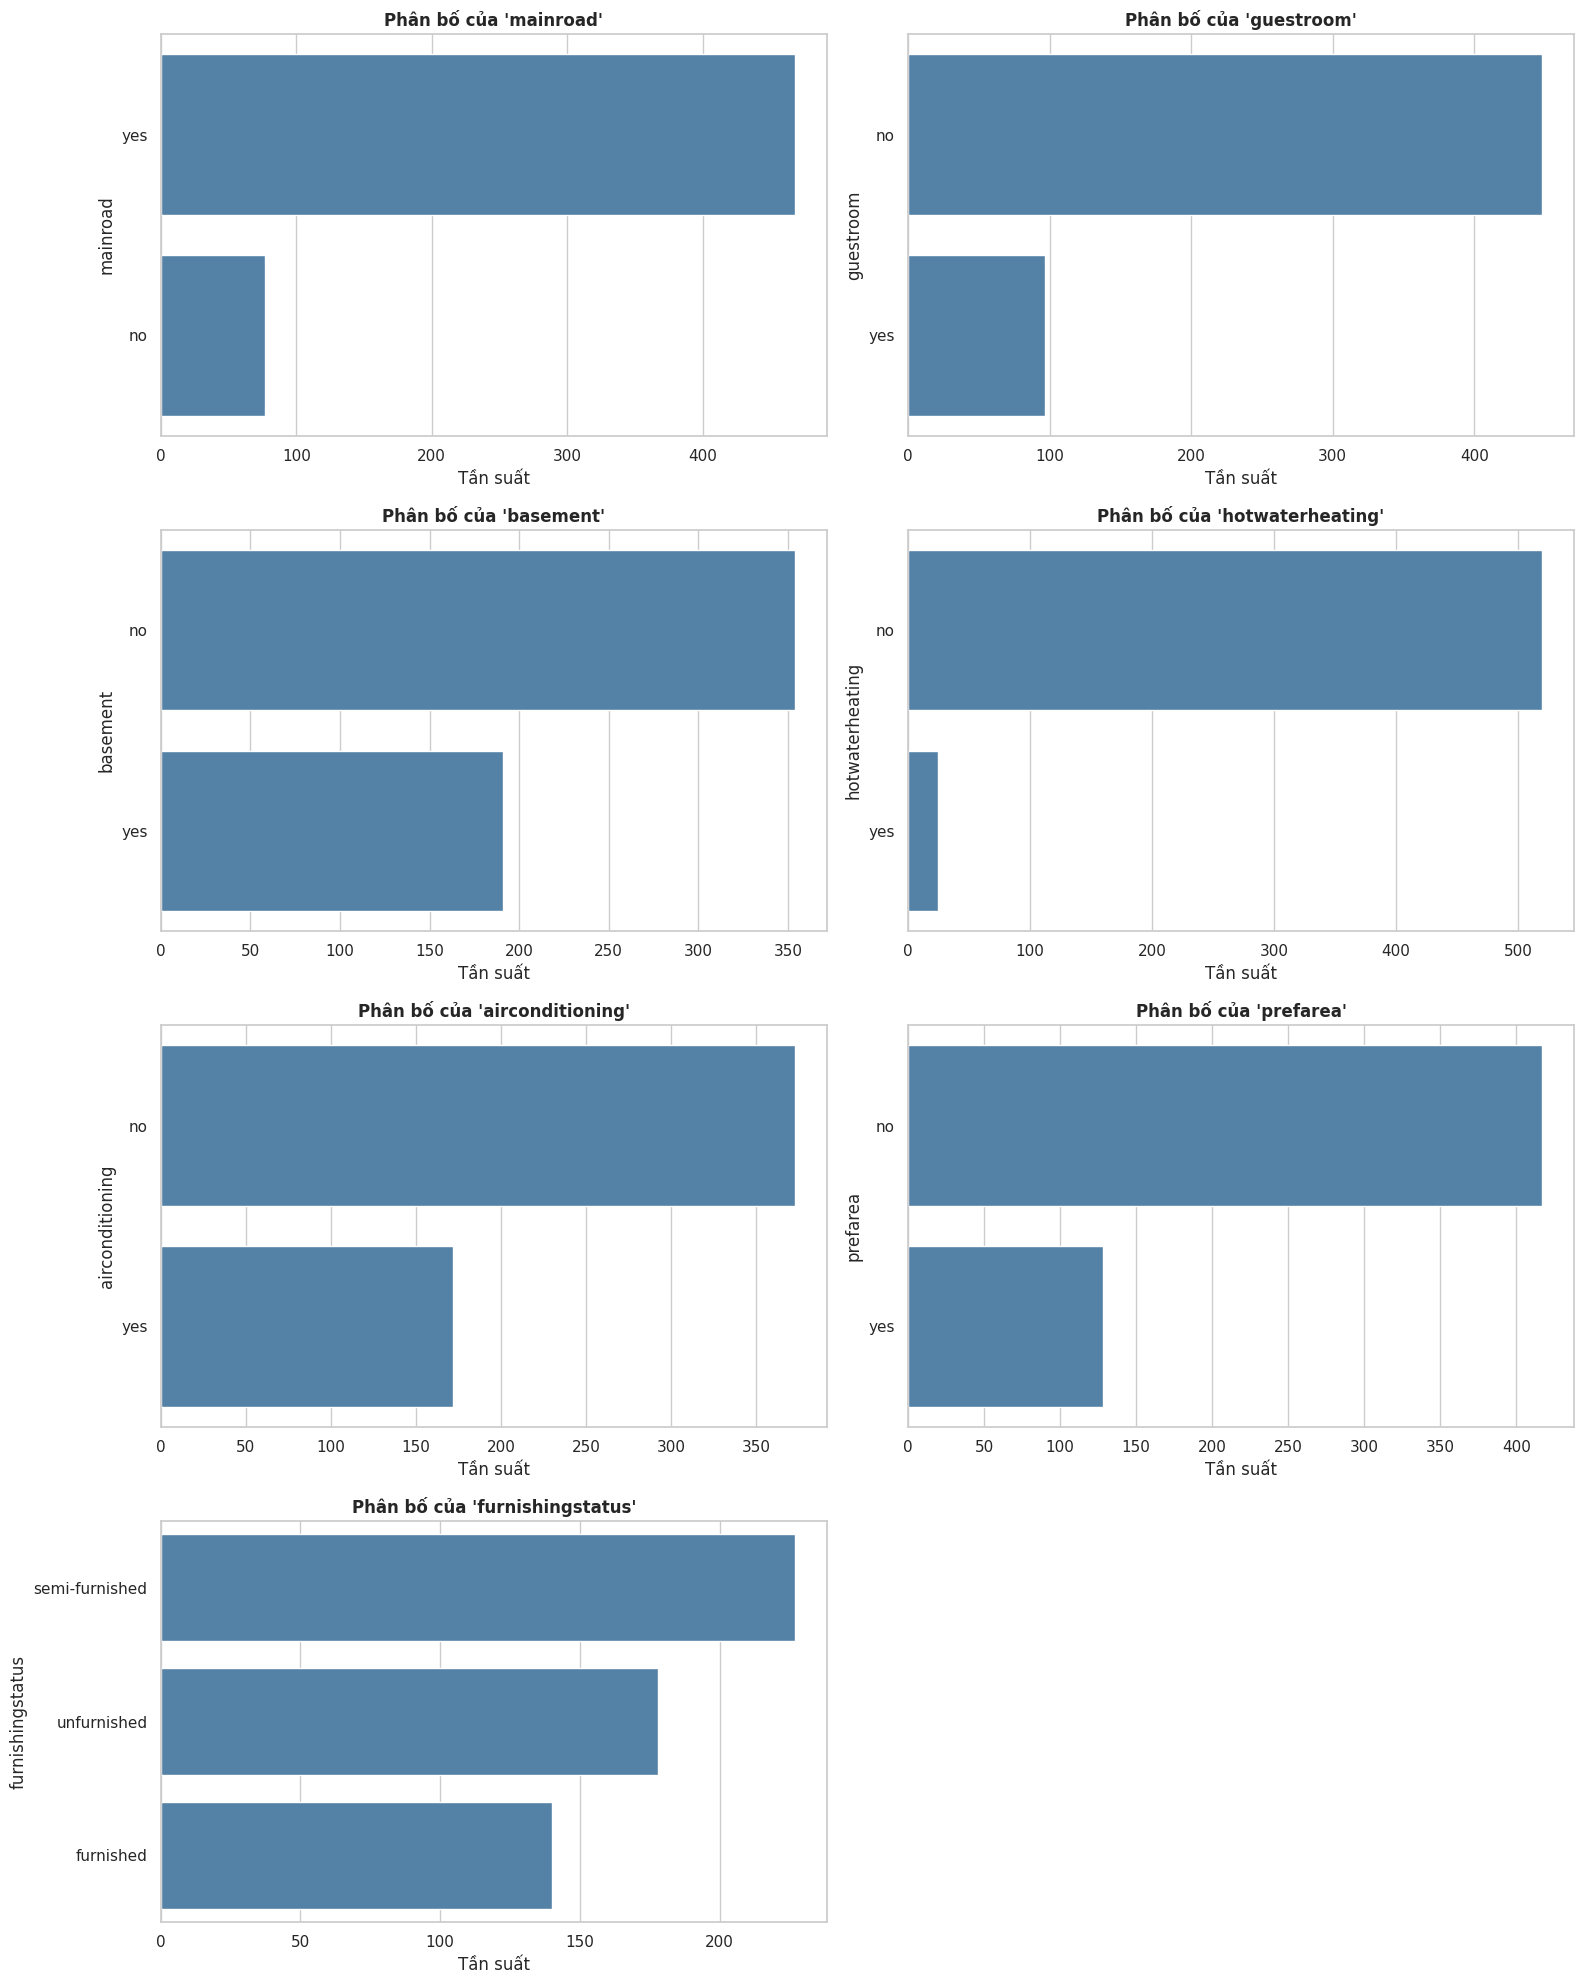

In [10]:
sns.set(style="whitegrid")

cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()


n = len(cat_columns)
cols = 2
rows = (n + 1) // cols

plt.figure(figsize=(16, rows * 5))

for i, attribute in enumerate(cat_columns):
    plt.subplot(rows, cols, i + 1)
    order = df[attribute].value_counts().index
    sns.countplot(data=df, y=attribute, order=order, color='steelblue')

    plt.title(f"Phân bố của '{attribute}'", fontsize=12, weight='bold')
    plt.xlabel("Tần suất")
    plt.ylabel(attribute)

plt.tight_layout()
plt.show()

**Lý do sử dụng countplot với dữ liệu này:**
Biểu đồ countplot của Seaborn được dùng để đếm số lượng các giá trị duy nhất trong một cột dạng phân loại (object hoặc category) và hiển thị trực quan dưới dạng cột hoặc thanh (bar).

**Hiểu rõ phân bố dữ liệu:**
* Ví dụ: mainroad có bao nhiêu căn nhà nằm trên đường chính (yes) và bao nhiêu không (no).
* Điều này giúp bạn đánh giá mức độ mất cân bằng (imbalance) trong dữ liệu.

**Phát hiện giá trị hiếm hoặc bất thường:**
* Ví dụ: Nếu có rất ít dòng với guestroom = yes, bạn có thể xem xét loại bỏ hoặc xử lý đặc biệt khi train model.

**Hỗ trợ tiền xử lý dữ liệu:**
* Ta có thể quyết định biến nào nên mã hóa one-hot, label encoding, hoặc gộp nhóm lại.

**Tiền đề cho phân tích chuyên sâu:**
* Biết được tần suất giúp bạn kết hợp các biến này với price để làm phân tích đa biến sau này (ví dụ: boxplot price theo furnishingstatus).

## Phát hiện dữ liệu ngoại lai

Text(0.5, 1.0, 'Giá nhà theo tình trạng nội thất')

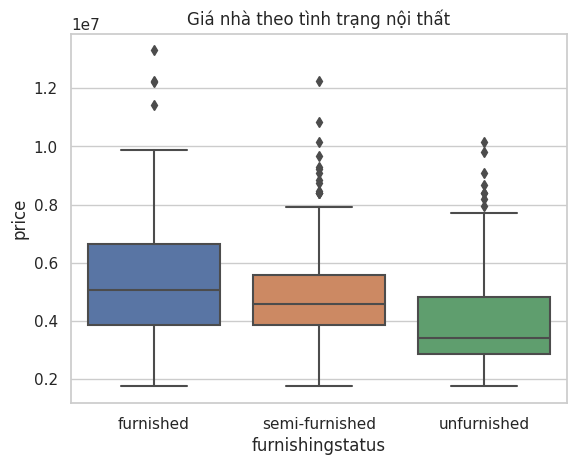

In [11]:
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.title("Giá nhà theo tình trạng nội thất")




**Biểu đồ boxplot (biểu đồ hộp)** thể hiện sự phân bố giá nhà (price) theo tình trạng nội thất (furnishingstatus) — và đây là một cách rất trực quan để so sánh giá trung vị, độ phân tán, và các ngoại lệ của từng nhóm.

**Nhận xét:**
1. Giá trung vị (median):

* furnished có giá trung vị cao nhất, tức nhà có nội thất đầy đủ thường có giá cao hơn.
* Sau đó là semi-furnished, rồi unfurnished (không nội thất) có giá trung vị thấp nhất.


⟶ Điều này phù hợp với kỳ vọng: nhà càng được trang bị nội thất đầy đủ thì thường có giá cao hơn.

2. Độ phân tán (interquartile range - IQR):
* furnished có khoảng giá dao động (IQR) tương đối rộng.
* unfurnished lại có IQR hẹp hơn, cho thấy giá thường ổn định hơn trong nhóm này.

3. Ngoại lệ (outliers):
* Cả 3 nhóm đều có nhiều điểm ngoại lệ (dấu chấm nhỏ phía trên hộp), đặc biệt là các căn có giá cao hơn mức bình thường.

* Điều này phản ánh một số căn có giá rất cao do vị trí, diện tích, hoặc các đặc điểm đặc biệt khác.

4. Phân bố tổng thể:
* Không có nhóm nào hoàn toàn không có giá thấp, nghĩa là tình trạng nội thất không phải yếu tố duy nhất quyết định giá, nhưng nó ảnh hưởng rõ rệt đến mức giá trung bình và cao nhất.

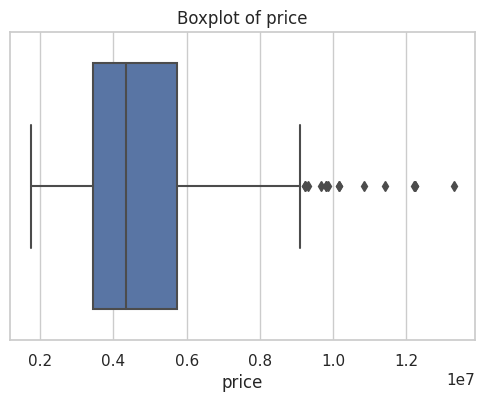

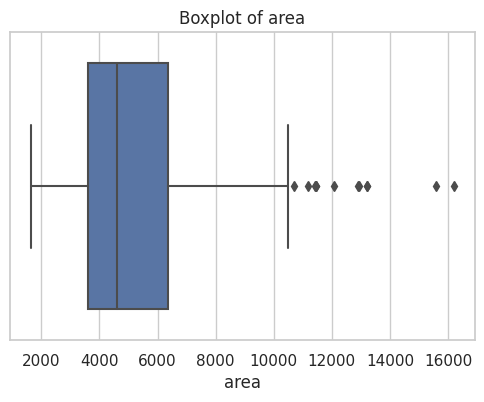

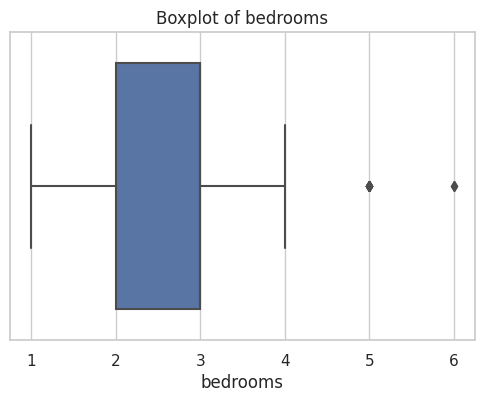

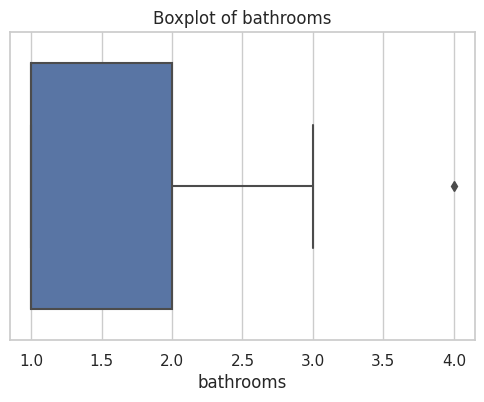

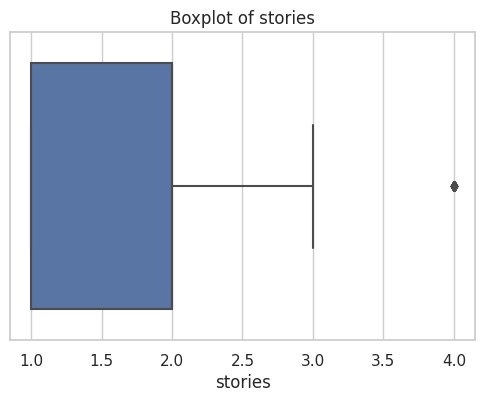

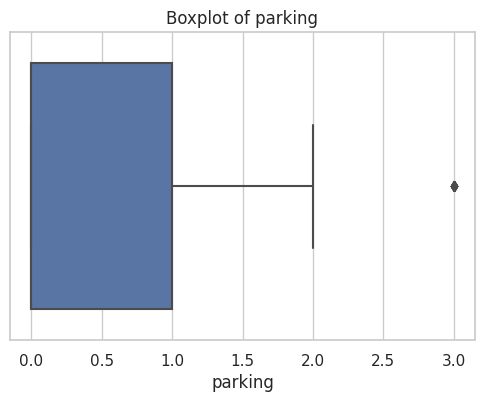

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

##  Phân bố giá nhà

Text(0.5, 1.0, 'Phân bố giá nhà')

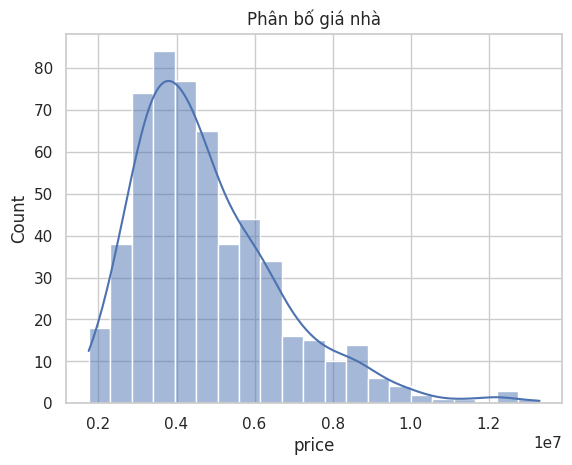

In [13]:
sns.histplot(df['price'], kde=True)
plt.title("Phân bố giá nhà")

1. Dạng phân bố:
* Phân bố lệch phải (right-skewed) – tức là phần lớn các căn nhà có giá thấp hơn, và chỉ có một số ít căn nhà có giá rất cao.
* Phân bố không đối xứng, đuôi kéo dài về bên phải ⟶ cho thấy có nhiều ngoại lệ (outliers) với giá rất cao.

2. Giá phổ biến:
* Giá nhà phổ biến nhất rơi vào khoảng 0.3 đến 0.5 tỷ (khoảng 3 triệu đến 5 triệu nếu dùng đơn vị trong biểu đồ là 10⁷).

* Đỉnh histogram cho thấy nhóm giá này có tần suất xuất hiện cao nhất.

3. Ngoại lệ:
* Một số căn nhà có giá cao tới hơn 1.2e7 (~12 triệu) – tuy rất ít nhưng kéo đuôi phân phối dài ra bên phải, khiến trung bình có thể cao hơn trung vị.

4. Đường KDE (đường cong mượt):
* Giúp thấy được dạng phân phối rõ ràng hơn so với các cột histogram.

* Khẳng định lại rằng dữ liệu không phân bố chuẩn (normal).

##  Hiển thị tần suất các giá trị phân loại

Text(0.5, 1.0, 'Tình trạng nội thất')

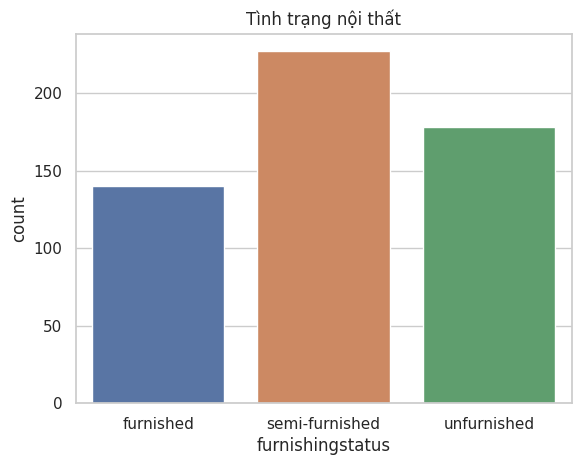

In [14]:
sns.countplot(x='furnishingstatus', data=df)
plt.title("Tình trạng nội thất")

1. Loại phổ biến nhất:
* semi-furnished (nội thất bán phần) là loại phổ biến nhất, với số lượng nhà cao nhất (hơn 220 căn).
2. Các loại còn lại:
* unfurnished (không có nội thất) đứng thứ hai với khoảng 175 căn.

* furnished (đầy đủ nội thất) có ít nhất, khoảng 140 căn.


##  Pairplot (Biểu đồ ma trận phân tán) . Giúp khám phá mối quan hệ giữa nhiều biến số cùng lúc:


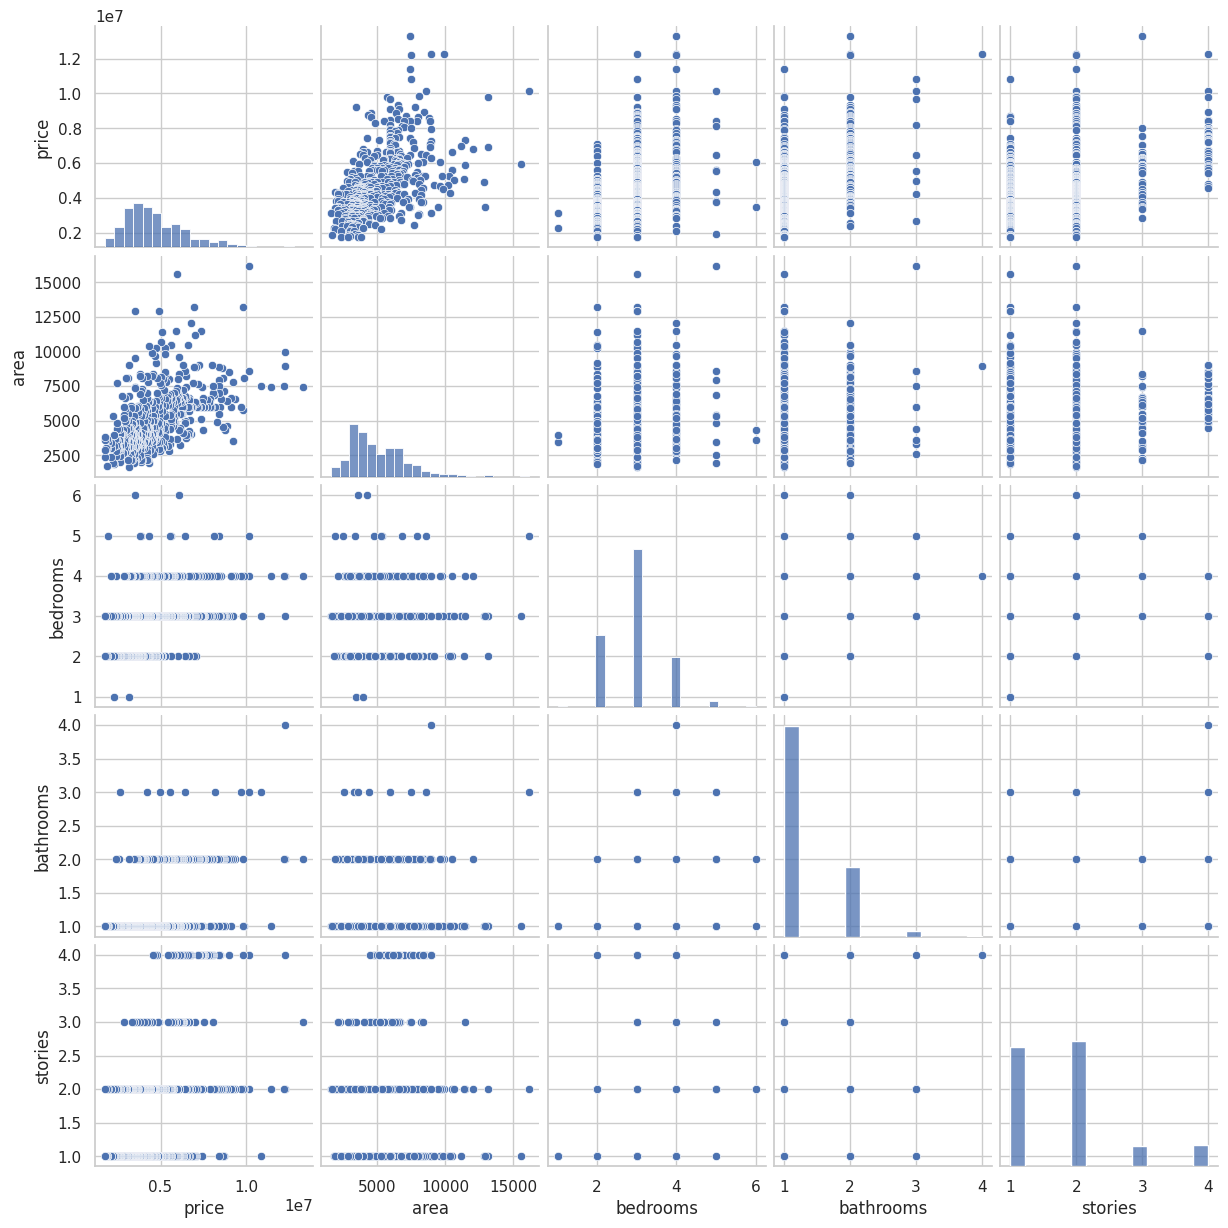

In [15]:
sns.pairplot(df[['price', 'area', 'bedrooms', 'bathrooms', 'stories']])


## Heatmap (bản đồ nhiệt) của hệ số tương quan

Text(0.5, 1.0, 'Ma trận tương quan')

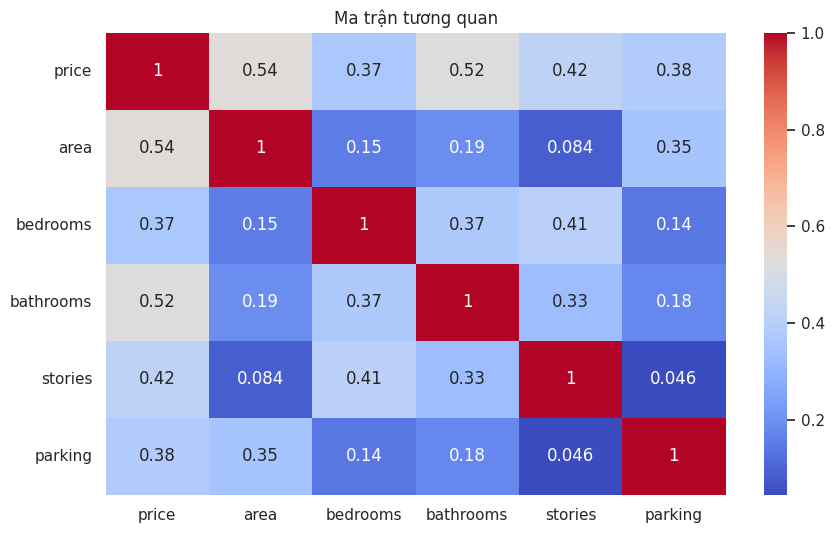

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan")

**Biến mục tiêu: price (giá nhà)**

**Tương quan cao nhất với:**

area: 0.54 ⟶ diện tích nhà ảnh hưởng mạnh nhất đến giá nhà.

bathrooms: 0.52 ⟶ Số phòng tắm cũng ảnh hưởng nhiều, hợp lý vì tiện nghi càng nhiều giá càng cao.

stories: 0.42 ⟶ Số tầng có ảnh hưởng mức vừa.

bedrooms: 0.37 ⟶ Phòng ngủ có ảnh hưởng thấp hơn kỳ vọng.

parking: 0.38 ⟶ Có chỗ đậu xe làm tăng giá trị, nhưng không quá mạnh.

**Tương quan yếu:**
area & stories: 0.084 ⟶ Diện tích và số tầng không đi đôi với nhau.

parking & stories: 0.046 ⟶ Gần như không liên quan.

Kết luận: 
* Không có cặp biến nào có tương quan rất cao (> 0.8) ⟶ Không lo multicollinearity nghiêm trọng nếu dùng các mô hình tuyến tính.
* price phụ thuộc nhiều vào diện tích, phòng tắm, và phần nào là tầng, chỗ đậu xe.

* bedrooms tưởng chừng quan trọng, nhưng hệ số tương quan với price lại khá thấp (0.37), cho thấy chất lượng và tiện ích có thể quan trọng hơn số lượng.


##   Biểu đồ Regression plot (đường hồi quy). Kiểm tra mối tương quan cụ thể:


Text(0.5, 1.0, 'Mối quan hệ giữa diện tích và giá')

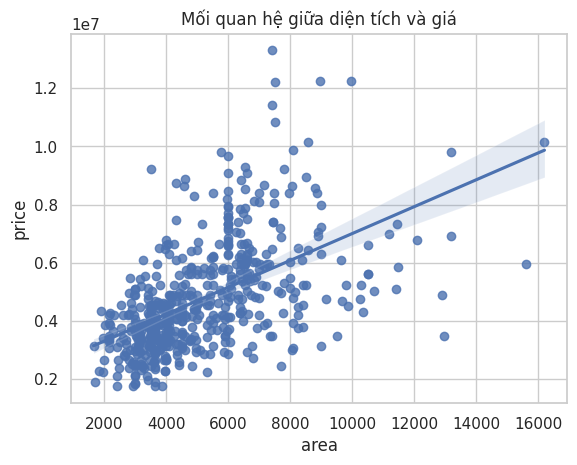

In [17]:
sns.regplot(x='area', y='price', data=df)
plt.title("Mối quan hệ giữa diện tích và giá")


Xu hướng dương rõ rệt: Đường hồi quy có độ dốc dương, cho thấy diện tích càng lớn thì giá bất động sản càng cao — điều này phù hợp với logic thị trường.

Phân tán dữ liệu: Dữ liệu có sự phân tán khá lớn, đặc biệt ở những diện tích lớn hơn, cho thấy có nhiều yếu tố khác ngoài diện tích ảnh hưởng đến giá, ví dụ như vị trí, tiện ích, pháp lý,...

Một số điểm ngoại lai (outliers):

* Có một số điểm có giá rất cao so với phần lớn dữ liệu có cùng diện tích.

* Có thể là biệt thự, nhà mặt tiền, hoặc vị trí cực kỳ đắc địa.

##  Tiền xử lí

# Xử lí ngoại lai

In [18]:
import pandas as pd

# Đọc dữ liệu
housing = pd.read_csv("/kaggle/input/housng-dataset/Housing.csv")
df = housing.copy()

# Các cột số cần xử lý
numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# ----🔹 1. Đếm số lượng ngoại lai TRƯỚC khi xử lý (dùng IQR) ----
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers_before = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                   (df[numeric_cols] > (Q3 + 1.5 * IQR)))

print("🔍 Số lượng ngoại lai trước khi xử lý:")
print(outliers_before.sum())

# ----🔹 2. Xử lý ngoại lai bằng capping ----
df_capped = df.copy()
for col in numeric_cols:
    lower = Q1[col] - 1.5 * IQR[col]
    upper = Q3[col] + 1.5 * IQR[col]
    df_capped[col] = df_capped[col].clip(lower, upper)

# ----🔹 3. Đếm số lượng ngoại lai SAU khi xử lý ----
outliers_after = ((df_capped[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                  (df_capped[numeric_cols] > (Q3 + 1.5 * IQR)))

print("\n✅ Số lượng ngoại lai sau khi xử lý:")
print(outliers_after.sum())


🔍 Số lượng ngoại lai trước khi xử lý:
price        15
area         12
bedrooms     12
bathrooms     1
stories      41
parking      12
dtype: int64

✅ Số lượng ngoại lai sau khi xử lý:
price        0
area         0
bedrooms     0
bathrooms    0
stories      0
parking      0
dtype: int64


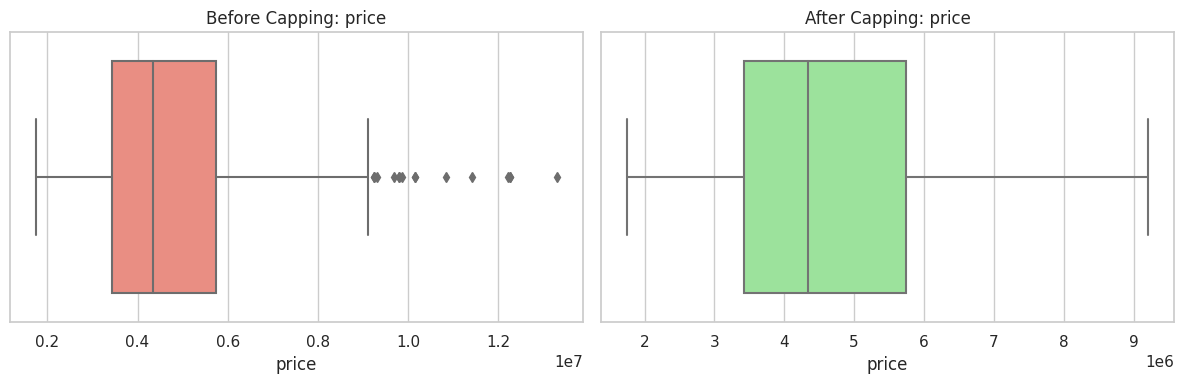

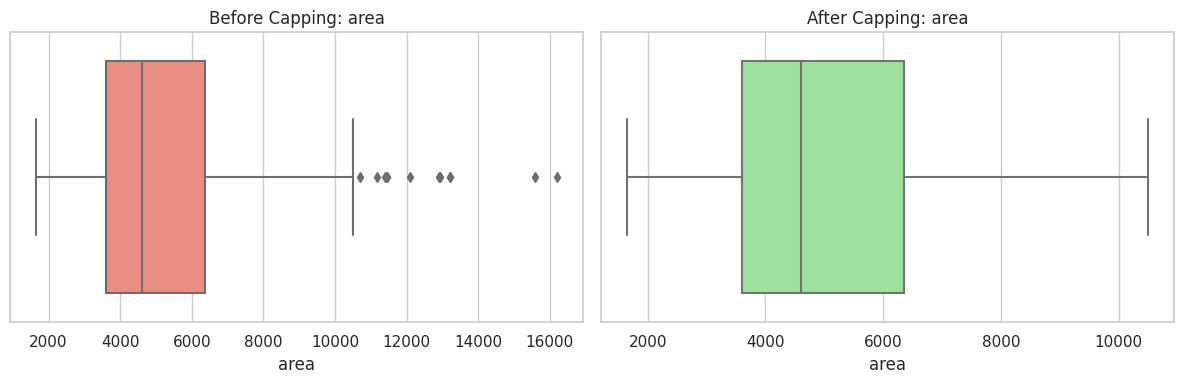

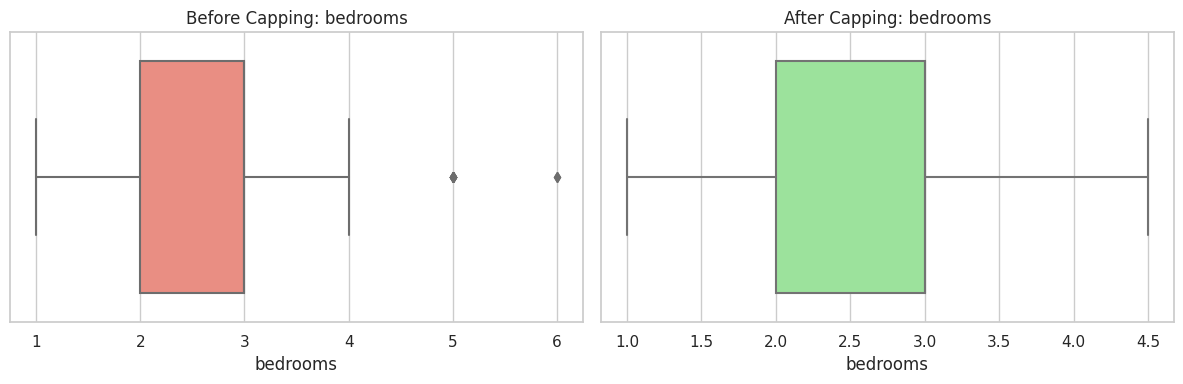

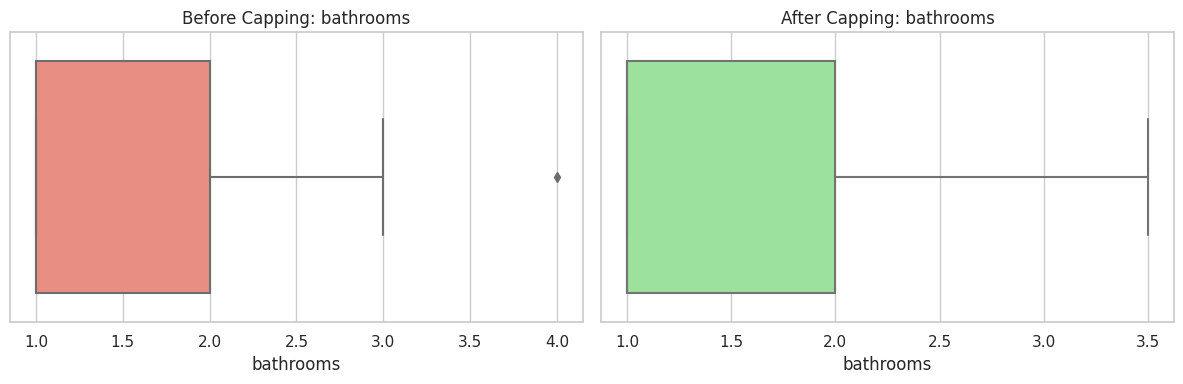

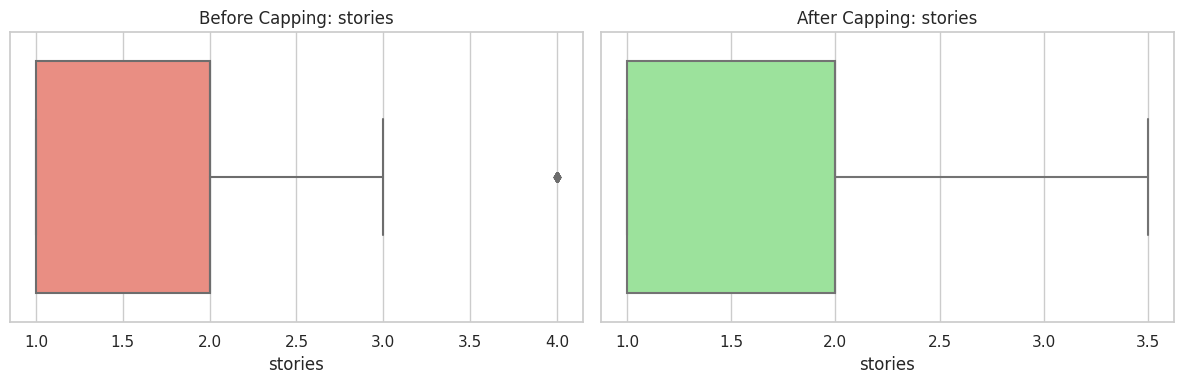

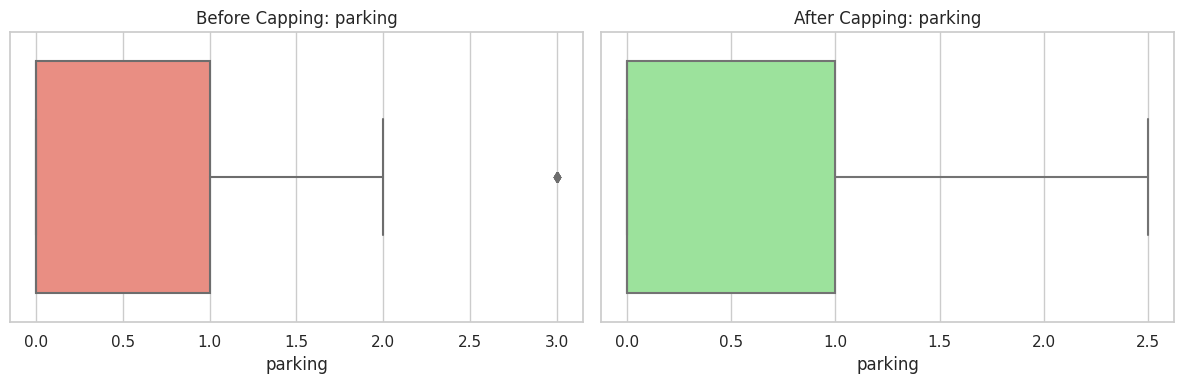

In [19]:
# ----🔹 Vẽ boxplot trước và sau xử lý ----
for col in numeric_cols:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    
    # Boxplot trước xử lý
    sns.boxplot(data=df, x=col, ax=axes[0], color='salmon')
    axes[0].set_title(f'Before Capping: {col}')
    
    # Boxplot sau xử lý
    sns.boxplot(data=df_capped, x=col, ax=axes[1], color='lightgreen')
    axes[1].set_title(f'After Capping: {col}')
    
    plt.tight_layout()
    plt.show()

* price:	    15 =>	Có một số ngôi nhà có giá bất thường, có thể là nhà rất cao cấp hoặc rất rẻ
* area:	    12=>	Diện tích có thể quá lớn hoặc quá nhỏ, gây ảnh hưởng đến phân phối
* bedrooms:	12=>	Số phòng ngủ bất thường có thể do biệt thự hoặc nhà rất nhỏ
* bathrooms:	1=>	Ngoại lai nhẹ, ít ảnh hưởng
* stories:	41=>	Đây là cột có nhiều ngoại lai nhất – có thể do số tầng vượt chuẩn
* parking:	12=>	Có những nhà có quá nhiều chỗ đậu xe – không phổ biến

Trước xử lý: Các ngoại lai này nếu không xử lý sẽ ảnh hưởng đến:

* Kết quả huấn luyện mô hình (học lệch theo các giá trị bất thường).
* Hiệu suất của các mô hình nhạy với phân phối (như hồi quy tuyến tính, KNN...).

Sau khi xử lí, toàn bộ ngoại lai đã được xử lý gọn gàng

Capping (giới hạn giá trị vượt quá ngưỡng) giúp:
* Giữ lại toàn bộ mẫu dữ liệu gốc (không loại bỏ).
* Giảm ảnh hưởng tiêu cực của giá trị cực đoan đến mô hình.
* Ổn định phân phối của các đặc trưng, giúp mô hình học tốt hơn.

Tổng kết nhận xét
* Việc xử lý ngoại lai bằng phương pháp IQR Capping là hợp lý và hiệu quả.
* Dữ liệu sau xử lý không còn điểm bất thường, giúp đảm bảo chất lượng cho các bước tiền xử lý tiếp theo như chuẩn hóa, huấn luyện mô hình học máy.
* Phương pháp này bảo toàn thông tin, tránh mất mẫu dữ liệu như khi loại bỏ hoàn toàn.

# Giảm chiều

Dùng PCA để giảm chiều

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

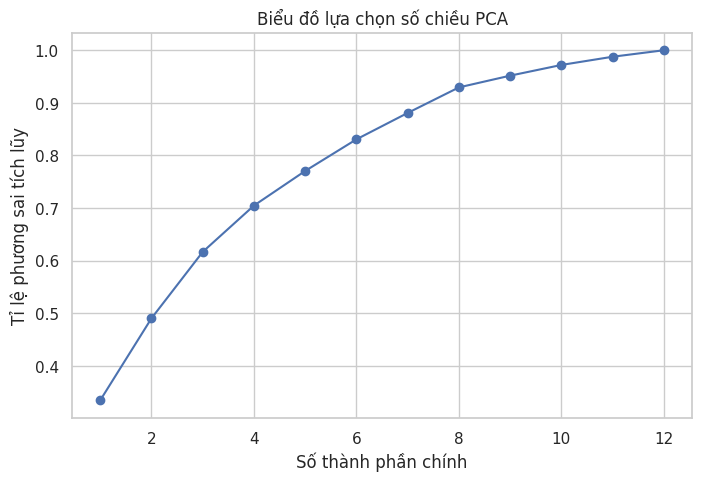

In [21]:


# Bước 1: Xác định cột mục tiêu
target_col = df_capped.columns[0]  # cột 'price'

# Bước 2: Xác định cột liên tục và phân loại
continuous_cols = df_capped.select_dtypes(include=['float64', 'int64']).columns.drop(target_col, errors='ignore')
categorical_cols = df_capped.select_dtypes(include=['object']).columns

# Bước 3: Chuẩn hóa các cột liên tục
scaler = MinMaxScaler()
df_capped[continuous_cols] = scaler.fit_transform(df_capped[continuous_cols])

# Bước 4: Label encode các cột phân loại (yes/no → 1/0)
le = LabelEncoder()
for col in categorical_cols:
    df_capped[col] = le.fit_transform(df_capped[col])


# Bước 5: Tách X, y
X = df_capped.drop(columns=[target_col])
y = df_capped[target_col]

# Bước 6: PCA - Xem biểu đồ phương sai tích lũy
pca = PCA()
X_pca_full = pca.fit_transform(X)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Số thành phần chính')
plt.ylabel('Tỉ lệ phương sai tích lũy')
plt.title('Biểu đồ lựa chọn số chiều PCA')
plt.grid(True)
plt.show()

# Bước 7: Giảm chiều bằng PCA với số chiều giữ lại (còn lại 5 chiều)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X)


* Trục hoành: Số thành phần chính được chọn (số chiều sau khi giảm).
* Trục tung: Tỉ lệ phương sai tích lũy – thể hiện lượng thông tin được giữ lại.

Nhận xét về việc áp dụng PCA
1. PCA hiệu quả trong giảm chiều
Để đạt 90% phương sai tích lũy, bạn chỉ cần khoảng 8 thành phần chính.

Dữ liệu gốc có 12 đặc trưng, vậy PCA giúp bạn giảm từ 12 → 8 chiều (giảm khoảng 33%).

2. Tốc độ hội tụ tốt
Phương sai tăng dần đều qua các thành phần đầu tiên → các thành phần đầu chứa phần lớn thông tin.

Ví dụ:

* 4 thành phần đầu giữ được khoảng 60% thông tin.

* 6 thành phần đầu giữ được khoảng 78–80% thông tin.

3. Không có “elbow” rõ ràng
Đồ thị không có góc gãy mạnh (elbow) → không có ngưỡng rõ ràng mà sau đó phương sai tăng chậm lại đáng kể.

Tuy nhiên, sau thành phần thứ 8, đường cong bắt đầu tiệm cận 1.0, tức là các thành phần sau thêm rất ít thông tin → có thể bỏ qua.

Kết luận

Việc chọn áp dụng PCA(n_components=0.9) tương đương với chọn  8 thành phần chính:
* Giảm chiều đáng kể (12 → 8).
* Giữ lại được 90% thông tin, rất phù hợp để dùng làm input cho các mô hình học máy.

Kết hợp với chuẩn hóa + label encoding trước đó sẽ giúp mô hình học hiệu quả hơn, tránh overfitting và cải thiện tốc độ huấn luyện.

In [22]:
# Gộp lại X_pca và y thành một DataFrame mới
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca[target_col] = y.values  # Thêm cột mục tiêu trở lại

# Xuất ra file CSV
df_pca.to_csv("housing_pca_processed.csv", index=False)
